In [7]:
import glob
import os
import subprocess

channels = ['B08', 'TCI', 'B05', 'B06', 'B07', 'B11', 'B12']
fnames = []
for scene_name in os.listdir('dataset_x/sentinel2_data/VN115'): # folder luu data
    image_fnames = glob.glob(os.path.join('dataset_x/sentinel2_data/VN115/VN115_*/*.tif'.format(scene_name)))
    # channel_to_fname = {file_name.split("_")[-2].replace(".tif", ""): file_name for file_name in image_fnames}
    channel_to_fname = {fname.split('_')[-9].split('.')[0]: fname for fname in image_fnames}
    selected_fnames = [channel_to_fname[channel] for channel in channels]
    #selected_fnames = channel_to_fname['TCI']
    fnames.extend(selected_fnames)
    
print(f"selected: {(fnames)}")
# subprocess.call([
#     'gdal_merge.py',
#     '-o', 'dataset_x/results/stack_thaibinh_ms9.tif',
#     # Keep bands separate in output file.
#     '-separate',
# ] + fnames)

selected: ['dataset_x/sentinel2_data/VN115/VN115_05_2024_12_2024_S2_B8/VN115_B08_B08_05_2024_12_2024_S2_B08_Image4.tif', 'dataset_x/sentinel2_data/VN115/VN115_05_2024_11_2024_S2/VN115_TCI_TCI_05_2024_11_2024_S2_TCI_Image3.tif', 'dataset_x/sentinel2_data/VN115/VN115_B05_2024_05_01_2024_11_01_S2/VN115_B05_2024_05_01_2024_11_01_S2_Image6.tif', 'dataset_x/sentinel2_data/VN115/VN115_B06_2024_05_01_2024_11_01_S2/VN115_B06_2024_05_01_2024_11_01_S2_Image4.tif', 'dataset_x/sentinel2_data/VN115/VN115_B07_2024_05_01_2024_11_01_S2/VN115_B07_2024_05_01_2024_11_01_S2_Image5.tif', 'dataset_x/sentinel2_data/VN115/VN115_B11_2024_05_01_2024_11_01_S2/VN115_B11_2024_05_01_2024_11_01_S2_Image6.tif', 'dataset_x/sentinel2_data/VN115/VN115_B12_2024_05_01_2024_11_01_S2/VN115_B12_2024_05_01_2024_11_01_S2_Image8.tif', 'dataset_x/sentinel2_data/VN115/VN115_05_2024_12_2024_S2_B8/VN115_B08_B08_05_2024_12_2024_S2_B08_Image4.tif', 'dataset_x/sentinel2_data/VN115/VN115_05_2024_11_2024_S2/VN115_TCI_TCI_05_2024_11_2024_

/tmp/ipykernel_16750/1384372430.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_pathc, map_location=device)


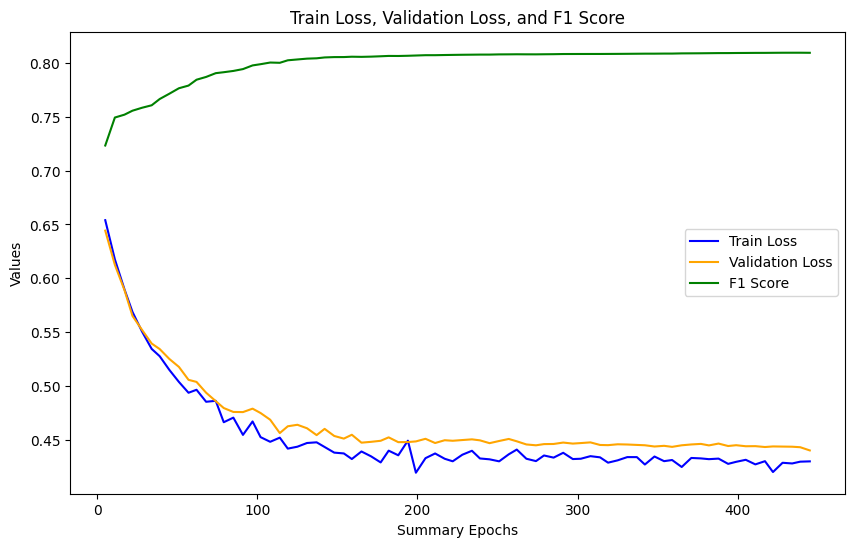

In [16]:
import matplotlib.pyplot as plt
import torch 

device = torch.device("cpu")
weights_pathc = 'dataset_x/output_weights/rice_ms_9/last.pth'
state_dict = torch.load(weights_pathc, map_location=device)

train_loss = state_dict['train_loss']
val_loss = state_dict['val_loss']
f1_score = state_dict['val_score']
epochs = state_dict['epoch']
lr = state_dict['optimizer.param_groups[0][lr]']
if len(train_loss) == len(val_loss) == len(f1_score):
    # epochs = list(range(1, len(train_loss) + 1))
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss', color='blue')
    plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
    plt.plot(epochs, f1_score, label='F1 Score', color='green')
    # plt.plot(epochs, lr, label='Learning rate', color='red', linestyle='--')

    plt.xlabel('Summary Epochs')
    plt.ylabel('Values')
    plt.title('Train Loss, Validation Loss, and F1 Score')
    plt.legend()
    
    plt.show()
else:
    print("fail")


# evaluate

In [2]:
import json
import numpy as np
import os, os.path
import rasterio.features
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix
import shapely
import skimage.draw
import skimage.io
import skimage.morphology
import tqdm
import torch
import torchvision

import satlas.model.dataset
import satlas.util

# Match predicted points with ground truth points to compute precision and recall.
def compute_loc_performance(gt_array, pred_array, eval_type, distance_tolerance, iou_threshold):
    # distance_matrix below doesn't work when preds is empty, so handle that first
    if len(pred_array) == 0:
        return [], [], gt_array.tolist()

    # Different matrix comparison depending on evaluating using center or IoU
    if eval_type == 'center':
        # Building distance matrix using Euclidean distance pixel space
        # multiplied by the UTM resolution (10 m per pixel)
        dist_mat = distance_matrix(pred_array, gt_array, p=2)
        dist_mat[dist_mat > distance_tolerance] = 99999
    elif eval_type == 'iou':
        # Compute pair-wise IoU between the current class targets and all predictions
        dist_mat = torchvision.ops.box_iou(gt_array, pred_array)
        dist_mat[dist_mat < iou_threshold] = 99999
        dist_mat = torch.transpose(dist_mat, 1, 0).cpu().detach().numpy()

    # Using Hungarian matching algorithm to assign lowest-cost gt-pred pairs
    rows, cols = linear_sum_assignment(dist_mat)

    if eval_type == 'center':
        tp_inds = [
            {"pred_idx": rows[ii], "gt_idx": cols[ii]}
            for ii in range(len(rows))
            if dist_mat[rows[ii], cols[ii]] < distance_tolerance
        ]
    elif eval_type == 'iou':
        tp_inds = [
            {"pred_idx": rows[ii], "gt_idx": cols[ii]}
            for ii in range(len(rows))
            if dist_mat[rows[ii], cols[ii]] > iou_threshold
        ]

    tp = [
        {'pred': pred_array[a['pred_idx']].tolist(), 'gt': gt_array[a['gt_idx']].tolist()}
        for a in tp_inds
    ]
    tp_inds_pred = set([a['pred_idx'] for a in tp_inds])
    tp_inds_gt = set([a['gt_idx'] for a in tp_inds])
    fp = [pred_array[i].tolist() for i in range(len(pred_array)) if i not in tp_inds_pred]
    fn = [gt_array[i].tolist() for i in range(len(gt_array)) if i not in tp_inds_gt]

    return tp, fp, fn

def point_score(gt, pred, eval_type, distance_tolerance=20, iou_threshold=0.5):
    tp, fp, fn = [], [], []

    for scene_id in gt.keys():
        cur_tp, cur_fp, cur_fn = compute_loc_performance(gt[scene_id], pred[scene_id], eval_type, distance_tolerance, iou_threshold)
        tp += [{'scene_id': scene_id, 'pred': a['pred'], 'gt': a['gt']} for a in cur_tp]
        fp += [{'scene_id': scene_id, 'point': a} for a in cur_fp]
        fn += [{'scene_id': scene_id, 'point': a} for a in cur_fn]

    return len(tp), len(fp), len(fn)

class SegmentAccuracyEvaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.task = task
        self.detail_func = detail_func
        self.scores = []

    def evaluate(self, valid, gt, pred):
        pred_argmax = pred.argmax(dim=1)
        score = (((pred_argmax == gt) & valid).float().sum() / torch.count_nonzero(valid))
        self.scores.append(score.item())

        if self.detail_func:
            # Get per-class scores.
            for cls_id, cls_name in enumerate(self.task['categories']):
                cls_mask = ((gt == cls_id) & valid).long()
                cls_count = torch.count_nonzero(cls_mask).item()
                if cls_count == 0:
                    continue

                scores = ((pred_argmax == gt) & valid).long()
                correct = (scores*cls_mask).sum()
                score = correct.item() / cls_count

                self.detail_func('{}_{}'.format(self.task['name'], cls_name), score)

    def score(self):
        if len(self.scores) == 0:
            score = 0
        else:
            score = np.mean(self.scores)

        return score, None

class SegmentLogProbEvaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.scores = []

    def evaluate(self, valid, gt, pred):
        # Select output probabilities corresponding to the ground truth class indices.
        index = gt[:, None, :, :]
        probs = pred.gather(dim=1, index=index)[:, 0, :, :]
        score = ((torch.log(probs) * valid.float()).sum() / torch.count_nonzero(valid))
        self.scores.append(score.item())

    def score(self):
        if len(self.scores) == 0:
            score = 0
        else:
            score = np.mean(self.scores)

        return score, None

class SegmentF1Evaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.evaluator = BinSegmentF1Evaluator(task, spec, detail_func=detail_func, params=params)

    def evaluate(self, valid, gt, pred):
        gt = torch.nn.functional.one_hot(gt.long(), num_classes=pred.shape[1]).permute(0, 3, 1, 2)
        return self.evaluator.evaluate(valid, gt, pred)

    def score(self):
        return self.evaluator.score()

class SegmentMIOUEvaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.n_classes = len(task['categories'])
        self.scores = []

    def evaluate(self, valid, gt, pred):
        gt = torch.flatten(gt)
        pred = torch.flatten(pred.argmax(dim=1))

        iou = 0
        n_observed = self.n_classes
        for i in range(self.n_classes):
            y_t = (gt == i).to(torch.int32)
            y_p = (pred == i).to(torch.int32)

            inter = torch.sum(y_t * y_p)
            union = torch.sum((y_t + y_p > 0).to(torch.int32))

            if union == 0:
                n_observed -= 1
            else:
                iou += inter / union

        self.scores.append((iou / n_observed).item())

    def score(self):
        if len(self.scores) == 0:
            score = 0
        else:
            score = np.mean(self.scores)

        return score, None

class BinSegmentAccuracyEvaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.scores = []

    def evaluate(self, valid, gt, pred):
        score = ((((pred > 0.5) == (gt > 0.5)) & valid).float().sum() / torch.count_nonzero(valid)).item()
        self.scores.append(score.item())

    def score(self):
        if len(self.scores) == 0:
            score = 0
        else:
            score = np.mean(self.scores)

        return score, None

class BinSegmentF1Evaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        '''
        params: list of thresholds, one for each class.
        '''
        self.task = task
        self.detail_func = detail_func

        # Set thresholds: each class can have multiple threshold options.
        num_classes = len(self.task['categories'])
        if params:
            self.thresholds = [[threshold] for threshold in params]
        else:
            self.thresholds = [[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95] for _ in range(num_classes)]

        self.gt_counts = [0 for _ in range(len(self.thresholds))]
        self.true_positives = [[0]*len(self.thresholds[i]) for i in range(len(self.thresholds))]
        self.false_positives = [[0]*len(self.thresholds[i]) for i in range(len(self.thresholds))]
        self.false_negatives = [[0]*len(self.thresholds[i]) for i in range(len(self.thresholds))]

    def evaluate(self, valid, gt, pred):
        for cls_idx, cls_thresholds in enumerate(self.thresholds):
            for threshold_idx, threshold in enumerate(cls_thresholds):
                pred_bin = (pred[:, cls_idx, :, :] > threshold) & valid
                gt_bin = (gt[:, cls_idx, :, :] > threshold) & valid
                tp = torch.count_nonzero(pred_bin & gt_bin).item()
                fp = torch.count_nonzero(pred_bin & torch.logical_not(gt_bin)).item()
                fn = torch.count_nonzero(torch.logical_not(pred_bin) & gt_bin).item()
                self.gt_counts[cls_idx] += torch.count_nonzero(gt_bin).item()
                self.true_positives[cls_idx][threshold_idx] += tp
                self.false_positives[cls_idx][threshold_idx] += fp
                self.false_negatives[cls_idx][threshold_idx] += fn

    def score(self):
        best_scores = []
        best_thresholds = []

        for cls_idx, cls_thresholds in enumerate(self.thresholds):
            if self.gt_counts[cls_idx] == 0:
                best_thresholds.append(0.5)
                continue

            best_score = None
            best_threshold = None

            for threshold_idx, threshold in enumerate(cls_thresholds):
                tp = self.true_positives[cls_idx][threshold_idx]
                fp = self.false_positives[cls_idx][threshold_idx]
                fn = self.false_negatives[cls_idx][threshold_idx]

                if tp + fp == 0:
                    precision = 0
                else:
                    precision = tp / (tp + fp)

                if tp + fn == 0:
                    recall = 0
                else:
                    recall = tp / (tp + fn)

                if precision + recall < 0.01:
                    f1 = 0
                else:
                    f1 = 2 * precision * recall / (precision + recall)

                if self.detail_func:
                    self.detail_func('{}_{}@{}'.format(self.task['name'], self.task['categories'][cls_idx], threshold), f1)

                if best_score is None or f1 > best_score:
                    best_score = f1
                    best_threshold = threshold

            best_scores.append(best_score)
            best_thresholds.append(best_threshold)

            if self.detail_func:
                self.detail_func('{}_{}'.format(self.task['name'], self.task['categories'][cls_idx]), best_score)

        if len(best_scores) == 0:
            return 0.0, best_thresholds

        return np.mean(best_scores), best_thresholds

class RegressSimpleEvaluator(object):
    def __init__(self, task, spec, cmp_func, detail_func=None, params=None):
        self.scores = []
        self.cmp_func = cmp_func

    def evaluate(self, valid, gt, pred):
        pred = torch.clip(pred, 0, 255)
        score = (self.cmp_func(pred/255, gt/255) * valid.float()).sum() / torch.count_nonzero(valid)
        self.scores.append(score.item())

    def score(self):
        if len(self.scores) == 0:
            score = 0
        else:
            score = np.mean(self.scores)

        return -score, None

class RegressMseEvaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.evaluator = RegressSimpleEvaluator(
            task=task,
            spec=spec,
            cmp_func=lambda pred, gt: torch.square(pred - gt),
            detail_func=detail_func,
            params=params
        )

    def evaluate(self, valid, gt, pred): return self.evaluator.evaluate(valid, gt, pred)
    def score(self): return self.evaluator.score()

class RegressL1Evaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.evaluator = RegressSimpleEvaluator(
            task=task,
            spec=spec,
            cmp_func=lambda pred, gt: torch.abs(pred - gt),
            detail_func=detail_func,
            params=params
        )

    def evaluate(self, valid, gt, pred): return self.evaluator.evaluate(valid, gt, pred)
    def score(self): return self.evaluator.score()

class DetectF1Evaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        '''
        params: list of thresholds, one for each class.
        '''
        self.eval_type = spec.get('EvalType', 'center')
        self.task = task
        self.detail_func = detail_func

        # Set thresholds: each class can have multiple threshold options.
        num_classes = len(self.task['categories'])
        if params:
            self.thresholds = [[threshold] for threshold in params]
        else:
            self.thresholds = [[0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95] for _ in range(num_classes)]

        self.true_positives = [[0]*len(self.thresholds[i]) for i in range(len(self.thresholds))]
        self.false_positives = [[0]*len(self.thresholds[i]) for i in range(len(self.thresholds))]
        self.false_negatives = [[0]*len(self.thresholds[i]) for i in range(len(self.thresholds))]

    def evaluate(self, gt_raw, pred_raw, iou_threshold=0.5):

        # Compute F1 score for each class individually, at each of that class' score thresholds
        for cls_idx, cls_thresholds in enumerate(self.thresholds):

            if cls_idx == 0:
                continue

            # Filter out ground truth objects with the current class label
            # If the evaluation type is center-based, replace boxes with centers
            gt = {}
            for image_idx, target in enumerate(gt_raw):
                # Get the relevant boxes (i.e., matching cls).
                # Have to handle no-box case separately since labels length is >= 1.
                if len(target['boxes']) == 0:
                    boxes = target['boxes'].numpy()
                else:
                    boxes = target['boxes'][target['labels'] == cls_idx, :].numpy()

                if self.eval_type == 'center':
                    gt[image_idx] = np.stack([
                        (boxes[:, 0] + boxes[:, 2])/2,
                        (boxes[:, 1] + boxes[:, 3])/2,
                    ], axis=1)
                elif self.eval_type == 'iou':
                    gt[image_idx] = boxes

            for threshold_idx, threshold in enumerate(cls_thresholds):
                pred = {}
                for image_idx, output in enumerate(pred_raw):
                    # Get the relevant boxes (i.e., matching cls and sufficient score).
                    if len(output['boxes']) == 0:
                        boxes = output['boxes'].numpy()
                    else:
                        selector = (output['scores'] >= threshold) & (output['labels'] == cls_idx)
                        boxes = output['boxes'][selector, :].numpy()

                    # If the evaluation type is center-based, replace the predicted boxes with centers
                    # Else if it is iou-based, keep the [x1,y1,x2,y2] box format
                    if self.eval_type == 'center':
                        pred[image_idx] = np.stack([
                            (boxes[:, 0] + boxes[:, 2])/2,
                            (boxes[:, 1] + boxes[:, 3])/2,
                        ], axis=1)
                    elif self.eval_type == 'iou':
                        pred[image_idx] = boxes

                tp, fp, fn = point_score(gt, pred, self.eval_type)
                self.true_positives[cls_idx][threshold_idx] += float(tp)
                self.false_positives[cls_idx][threshold_idx] += float(fp)
                self.false_negatives[cls_idx][threshold_idx] += float(fn)

    def score(self):
        best_scores = []
        best_thresholds = []

        for cls_idx, cls_thresholds in enumerate(self.thresholds):
            best_score = None
            best_threshold = None

            if cls_idx == 0:
                best_thresholds.append(0.5)
                continue

            for threshold_idx, threshold in enumerate(cls_thresholds):
                tp = self.true_positives[cls_idx][threshold_idx]
                fp = self.false_positives[cls_idx][threshold_idx]
                fn = self.false_negatives[cls_idx][threshold_idx]

                if tp + fp == 0:
                    precision = 0
                else:
                    precision = tp / (tp + fp)

                if tp + fn == 0:
                    recall = 0
                else:
                    recall = tp / (tp + fn)

                if precision + recall < 0.001:
                    f1 = 0
                else:
                    f1 = 2 * precision * recall / (precision + recall)

                if self.detail_func:
                    self.detail_func('{}_{}@{}_{}_{}'.format(self.task['name'], self.task['categories'][cls_idx], threshold, precision, recall), f1)

                if best_score is None or f1 > best_score:
                    best_score = f1
                    best_threshold = threshold

            best_scores.append(best_score)
            best_thresholds.append(best_threshold)

        # In all-background-class cases, avoid divide-by-zero errors
        if len(best_scores) == 0:
            return 0.0, best_thresholds

        return sum(best_scores) / len(best_scores), best_thresholds

class ClassificationAccuracyEvaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        self.task = task
        self.detail_func = detail_func

        num_classes = len(self.task['categories'])

        self.tot_samples = 0
        self.accuracies = []

    def evaluate(self, gt, pred):
        score = (pred.argmax(dim=1) == gt).float().sum()
        self.tot_samples += len(gt)
        self.accuracies.append(score.item())

    def score(self):
        if self.tot_samples == 0:
            return 0.0, None
        return sum(self.accuracies) / self.tot_samples, None


class ClassificationF1Evaluator(object):
    def __init__(self, task, spec, detail_func=None, params=None):
        '''
        params: list of thresholds, one for each class.
        '''
        self.task = task
        self.detail_func = detail_func

        # Set thresholds: each class can have multiple threshold options.
        num_classes = len(self.task['categories'])
        if params:
            self.thresholds = [[threshold] for threshold in params]
        else:
            self.thresholds = [list([x/100 for x in range(1, 100)]) for _ in range(num_classes)]

        self.samples = [[] for _ in range(len(self.thresholds))]

    def evaluate(self, gt, pred):
        for cls_idx in range(len(self.thresholds)):
            for example_idx in range(len(gt)):
                self.samples[cls_idx].append((pred[example_idx, cls_idx].item(), gt[example_idx].item() == cls_idx))

    def score(self):
        best_scores = []
        best_thresholds = []

        for cls_idx, cls_thresholds in enumerate(self.thresholds):
            # To compute scores at many thresholds, we iterate over samples from least probability to highest probability.
            # We start by computing tp/fp/fn as if the threshold is 0 (all samples predicted true).
            # Then during every iteration, we update tp/fp/fn incrementally as if the threshold were equal to the current sample's probability.
            cls_thresholds.sort()
            cls_samples = self.samples[cls_idx]
            cls_samples.sort(key=lambda sample: sample[0])
            threshold_idx = 0
            tp = sum([1 for sample in cls_samples if sample[1]])
            fp = sum([1 for sample in cls_samples if not sample[1]])
            fn = 0

            if tp == 0:
                # Skip this class if there are no positive examples.
                best_thresholds.append(0.5)
                continue

            best_score = 0
            best_threshold = 0.5

            def get_f1():
                if tp == 0:
                    return 0
                precision = tp / (tp + fp)
                recall = tp / (tp + fn)
                if precision + recall < 0.01:
                    return 0
                return 2 * precision * recall / (precision + recall)

            for sample_prob, sample_match in cls_samples:
                if threshold_idx >= len(cls_thresholds):
                    break
                while threshold_idx < len(cls_thresholds) and sample_prob > cls_thresholds[threshold_idx]:
                    cur_score = get_f1()
                    if cur_score > best_score:
                        best_score = cur_score
                        best_threshold = cls_thresholds[threshold_idx]
                    threshold_idx += 1

                # Update tp/fp/fn to account for the threshold passing above this sample's probability.
                if sample_match:
                    tp -= 1
                    fn += 1
                else:
                    fp -= 1

            best_scores.append(best_score)
            best_thresholds.append(best_threshold)

            if self.detail_func:
                self.detail_func('{}_{}'.format(self.task['name'], self.task['categories'][cls_idx]), best_score)

        if len(best_scores) == 0:
            return 0.0, best_thresholds

        return np.mean(best_scores), best_thresholds

evaluator_registry = {
    'segment': {
        'accuracy': SegmentAccuracyEvaluator,
        'logprob': SegmentLogProbEvaluator,
        'f1': SegmentF1Evaluator,
        'mIou': SegmentMIOUEvaluator,
    },
    'bin_segment': {
        'accuracy': BinSegmentAccuracyEvaluator,
        'f1': BinSegmentF1Evaluator,
    },
    'regress': {
        'mse': RegressMseEvaluator,
        'l1': RegressL1Evaluator,
    },
    'detect': {
        'f1': DetectF1Evaluator,
    },
    'instance': {
        'f1': DetectF1Evaluator,
    },
    'classification': {
        'accuracy': ClassificationAccuracyEvaluator,
        'f1': ClassificationF1Evaluator,
    },
    'multi-label-classification': {
        'accuracy': ClassificationAccuracyEvaluator,
    },
}

# Convert masks (in format produced by Mask R-CNN) to polygons.
# Returns list, where each element is list of polygons corresponding to that mask.
# Most masks will correspond to one polygon, but sometimes there may be multiple if the mask has several disjoint components.
# The masks and boxes arguments should be numpy arrays.
def polygonize_masks(masks, boxes):
    polygons = [[] for _ in masks]

    for box_idx, (mask, box) in enumerate(zip(masks, boxes)):
        mask = (mask > 0.5).astype(np.uint8)

        # We use rasterio for initial polygonization and rastachimp for polygon simplification.
        shapes = list(rasterio.features.shapes(mask))

        # Should have at least one shape for foreground and one for background.
        # If not, then it means there's no foreground (or background).
        if len(shapes) < 2:
            continue

        # Helper to convert mask coordinates (which is within the predicted box) to image coordinates.
        def mask_to_image(x, y):
            # Rescale.
            x = x * (box[2] - box[0]) / mask.shape[1]
            y = y * (box[3] - box[1]) / mask.shape[0]
            # Include offset.
            x += box[0]
            y += box[1]
            return int(x), int(y)

        for (shp, value) in shapes:
            # Discard shape corresponding to the background.
            if value != 1:
                continue

            # Convert to shapely and simplify.
            shp = shapely.geometry.shape(shp)
            shp = shp.simplify(tolerance=2)

            # Convert to our format, i.e., list of rings.
            # First ring is exterior ring and rest (if any) are interior holes.
            exterior = [mask_to_image(x, y) for x, y in shp.exterior.coords]
            interiors = [[mask_to_image(x, y) for x, y in interior.coords] for interior in shp.interiors]
            coords = [exterior] + interiors
            polygons[box_idx].append(coords)

    return polygons

# Convert segmentation class map to colors.
def segmentation_mask_to_color(task, label_im, gt=None):
    if task['type'] == 'segment':
        vis = np.zeros((label_im.shape[0], label_im.shape[1], 3), dtype='uint8')
        for cls, color in enumerate(task['colors']):
            vis[label_im == cls] = color

        if task.get('BackgroundInvalid', False) and gt:
            # Mask out pixels in label_im that are background in the ground truth labels.
            vis[gt == 0] = task['colors'][0]

    elif task['type'] == 'bin_segment':
        if label_im.dtype != bool:
            label_im = label_im > 0.5

        vis = np.zeros((label_im.shape[1], label_im.shape[2], 3), dtype='uint8')
        for cls, color in enumerate(task['colors']):
            vis[label_im[cls, :, :]] = color

    return vis

def visualize_outputs(task, image, outputs, targets=None, return_vis=False, return_out=False, evaluator_params=None):
    '''
    Returns output visualization and/or raw outputs given the task dict, input image, and outputs.
    Also returns gt visualization if targets is provided.
    '''
    task_type = task['type']

    # These will be overwritten with label visualizations if the task supports it and return_vis=True.
    vis_output = None
    vis_gt = None

    # These will be overwritten with the actual outputs if return_out=True.
    raw_outputs = None
    raw_output_format = None

    if task_type == 'segment':
        if evaluator_params:
            # Use user-provided score thresholds for each class.
            # If multiple classes have probability exceeding threshold at a pixel,
            # the pixel will end up colored based on the last class.
            pred_probs = outputs.cpu().numpy()
            pred_cls = np.zeros(pred_probs.shape[1:3], dtype=np.uint8)
            for cls_id, threshold in enumerate(evaluator_params):
                pred_cls[pred_probs[cls_id, :, :] > threshold] = cls_id
        else:
            pred_cls = outputs.argmax(dim=0).cpu().numpy()

        if return_vis:
            vis_output = segmentation_mask_to_color(task, pred_cls)
            if targets:
                vis_gt = segmentation_mask_to_color(task, targets['im'].numpy())

        if return_out:
            raw_outputs = pred_cls.astype(np.uint8)
            raw_output_format = 'png'

    elif task_type == 'bin_segment':
        cur_outputs = outputs.cpu().numpy()
        if evaluator_params:
            cur_outputs_bin = np.stack([
                cur_outputs[channel_idx, :, :] > evaluator_params[channel_idx]
                for channel_idx in range(cur_outputs.shape[0])
            ], axis=0)
        else:
            cur_outputs_bin = cur_outputs > 0.5

        if return_vis:
            vis_output = segmentation_mask_to_color(task, cur_outputs_bin)
            if targets:
                vis_gt = segmentation_mask_to_color(task, targets['im'].numpy() > 0.5)

        if return_out:
            enc = satlas.util.encode_multiclass_binary(cur_outputs_bin.transpose(1, 2, 0))
            raw_outputs = enc
            raw_output_format = 'npy'

    elif task_type == 'regress':
        output = np.clip(outputs.cpu().numpy(), 0, 255).astype(np.uint8)

        if return_vis:
            vis_output = output
            if targets:
                vis_gt = targets['im'].numpy()

        if return_out:
            raw_outputs = output
            raw_output_format = 'png'

    elif task_type == 'detect':
        output_boxes = outputs['boxes'].long().cpu().numpy()
        output_scores = outputs['scores'].cpu().numpy()
        output_categories = outputs['labels'].cpu().numpy()

        if evaluator_params:
            output_score_thresholds = np.array([evaluator_params[category_id] for category_id in output_categories], dtype=np.float32)
            wanted = output_scores >= output_score_thresholds

            output_boxes = output_boxes[wanted, :]
            output_scores = output_scores[wanted]
            output_categories = output_categories[wanted]

        if return_vis:
            def get_color(category_id):
                if 'colors' in task:
                    return task['colors'][category_id]
                return [255, 255, 0]

            vis_output = image.copy()

            for box_idx, box in enumerate(output_boxes):
                color = get_color(outputs['labels'][box_idx].item())
                left = satlas.util.clip(box[0], 0, vis_output.shape[1])
                top = satlas.util.clip(box[1], 0, vis_output.shape[0])
                right = satlas.util.clip(box[2], 0, vis_output.shape[1])
                bottom = satlas.util.clip(box[3], 0, vis_output.shape[0])
                vis_output[top:bottom, left:left+2, :] = color
                vis_output[top:bottom, right-2:right, :] = color
                vis_output[top:top+2, left:right, :] = color
                vis_output[bottom-2:bottom, left:right, :] = color

            if targets:
                gt_boxes = targets['boxes'].long().numpy()
                vis_gt = image.copy()
                for box_idx, box in enumerate(gt_boxes):
                    color = get_color(targets['labels'][box_idx].item())
                    left = satlas.util.clip(box[0], 0, vis_gt.shape[1])
                    top = satlas.util.clip(box[1], 0, vis_gt.shape[0])
                    right = satlas.util.clip(box[2], 0, vis_gt.shape[1])
                    bottom = satlas.util.clip(box[3], 0, vis_gt.shape[0])
                    vis_gt[top:bottom, left:left+2, :] = color
                    vis_gt[top:bottom, right-2:right, :] = color
                    vis_gt[top:top+2, left:right, :] = color
                    vis_gt[bottom-2:bottom, left:right, :] = color

        if return_out:
            raw_outputs = [(
                int(box[0]),
                int(box[1]),
                int(box[2]),
                int(box[3]),
                task['categories'][output_categories[i]],
                float(output_scores[i]),
            ) for i, box in enumerate(output_boxes)]
            raw_output_format = 'json'

    elif task_type == 'instance':
        output_boxes = outputs['boxes'].long().cpu().numpy()
        output_scores = outputs['scores'].cpu().numpy()
        output_categories = outputs['labels'].cpu().numpy()
        output_masks = outputs['masks'].cpu().numpy()[:, 0, :, :]

        if evaluator_params:
            output_score_thresholds = np.array([evaluator_params[category_id] for category_id in output_categories], dtype=np.float32)
            wanted = output_scores >= output_score_thresholds

            output_boxes = output_boxes[wanted, :]
            output_scores = output_scores[wanted]
            output_categories = output_categories[wanted]
            output_masks = output_masks[wanted, :, :]

        # Polygonize the masks.
        output_polygons = polygonize_masks(output_masks, output_boxes)

        if return_vis:
            def get_color(category_id):
                if 'colors' in task:
                    return task['colors'][category_id]
                return [255, 255, 0]

            vis_output = image.copy()

            # Draw the polygons on vis_output.
            # We first draw it on line_im, then dilate line_im, then apply it on vis_output.
            for box_idx, polygons in enumerate(output_polygons):
                color = get_color(outputs['labels'][box_idx].item())
                for coords in polygons:
                    exterior = np.array(coords[0], dtype=np.int32)
                    rows, cols = skimage.draw.polygon(exterior[:, 1], exterior[:, 0], shape=(vis_output.shape[0], vis_output.shape[1]))
                    vis_output[rows, cols, :] = color

            if targets:
                gt_boxes = targets['boxes'].long().numpy()
                gt_masks = targets['masks'].numpy()
                vis_gt = image.copy()
                for box_idx, mask in enumerate(gt_masks):
                    color = get_color(targets['labels'][box_idx].item())
                    vis_gt[mask > 0, :] = color

        if return_out:
            raw_outputs = []
            for box_idx, polygons in enumerate(output_polygons):
                category_name = task['categories'][output_categories[box_idx]]
                score = float(output_scores[box_idx])
                for coords in polygons:
                    raw_outputs.append([
                        'fake_polygon_id',
                        coords,
                        category_name,
                        score,
                        {}, # no properties
                    ])
            raw_output_format = 'json'

    elif task_type == 'classification':
        if return_out:
            category_id = torch.argmax(outputs).item()
            raw_outputs = "{}\n".format(category_id)
            raw_output_format = "txt"

    return vis_output, vis_gt, raw_outputs, raw_output_format

def evaluate(config, model, device, loader, half_enabled=False, vis_dir=None, probs_dir=None, out_dir=None, print_details=False, evaluator_params_list=None):
    # Is a specific task chosen for evaluation?
    selected_task = config.get('EvaluateTask', None)

    with torch.no_grad():
        all_losses = [[] for _ in config['Tasks']]

        # For computing detailed per-class scores and such, if print_details is set.
        details = {}
        def add_detail(k, score):
            if k not in details:
                details[k] = []
            details[k].append(score)
        detail_func = None
        if print_details:
            detail_func = add_detail

        # Initialize evaluators.
        evaluators = []
        for task_idx, spec in enumerate(config['Tasks']):
            task_name = spec['Name']
            task = spec['Task']
            task['name'] = task_name # Since we only pass the dict, not the name, to score functions.
            task_type = task['type']
            metric = spec.get('Metric', 'accuracy')

            if evaluator_params_list:
                evaluator_params = evaluator_params_list[task_idx]
            else:
                evaluator_params = None

            evaluator_cls = evaluator_registry[task_type][metric]
            evaluators.append(evaluator_cls(task=task, spec=spec, detail_func=detail_func, params=evaluator_params))

        if print_details:
            # Enable tqdm progress when details is on.
            loader = tqdm.tqdm(loader)

        for images, targets, info in loader:
            gpu_images = [image.to(device).float()/255 for image in images]
            gpu_targets = [
                [{k: v.to(device) for k, v in target_dict.items()} for target_dict in cur_targets]
                for cur_targets in targets
            ]

            with torch.cuda.amp.autocast(enabled=half_enabled):
                outputs, losses = model(gpu_images, gpu_targets, selected_task=selected_task)

            for task_idx, spec in enumerate(config['Tasks']):
                all_losses[task_idx].append(losses[task_idx].item())

                task_name = spec['Name']
                task = spec['Task']
                task_type = task['type']

                if selected_task and selected_task != task_name:
                    continue

                # Save output probabilities.
                # Do this before evaluator because for some task types,
                # we may skip the image based on gt validity.
                if probs_dir:
                    for image_idx, image in enumerate(images):
                        example_id = info[image_idx]['example_id']

                        if task_type in ['segment', 'bin_segment']:
                            cur_outputs = outputs[task_idx][image_idx, :, :, :].cpu().numpy()
                            np.save(os.path.join(probs_dir, '{}_{}.npy'.format(example_id, task_name)), cur_outputs)

                if task_type in ['segment', 'bin_segment', 'regress']:
                    valid = torch.stack([target[task_idx]['valid'] != 0 for target in targets], dim=0)
                    if torch.count_nonzero(valid) == 0:
                        continue

                    valid_im = torch.stack([target[task_idx]['valid_im'] for i, target in enumerate(gpu_targets) if valid[i]], dim=0)
                    gt = torch.stack([target[task_idx]['im'] for i, target in enumerate(gpu_targets) if valid[i]], dim=0)
                    pred = torch.stack([output for i, output in enumerate(outputs[task_idx]) if valid[i]], dim=0)

                    evaluators[task_idx].evaluate(valid_im, gt, pred)

                elif task_type == 'detect' or task_type == 'instance':
                    gt = []
                    pred = []
                    for target, output in zip(gpu_targets, outputs[task_idx]):
                        if not target[task_idx]['valid']:
                            continue
                        gt.append({
                            'boxes': target[task_idx]['boxes'].cpu(),
                            'labels': target[task_idx]['labels'].cpu(),
                        })
                        pred.append({
                            'boxes': output['boxes'].cpu(),
                            'labels': output['labels'].cpu(),
                            'scores': output['scores'].cpu(),
                        })
                    evaluators[task_idx].evaluate(gt, pred)

                elif task_type == 'classification':
                    valid = torch.stack([target[task_idx]['valid'] for target in gpu_targets], dim=0) > 0
                    if torch.count_nonzero(valid) == 0:
                        continue

                    gt = torch.cat([target[task_idx]['label'] for i, target in enumerate(gpu_targets) if valid[i]], dim=0)
                    pred = torch.stack([output for i, output in enumerate(outputs[task_idx]) if valid[i]], dim=0)
                    evaluators[task_idx].evaluate(gt, pred)

                elif task_type == 'multi-label-classification':
                    valid = torch.tensor([target[task_idx]['valid'] for target in gpu_targets]) > 0
                    if torch.count_nonzero(valid) == 0:
                        continue

                    gt = torch.cat([target[task_idx]['labels'] for i, target in enumerate(gpu_targets) if valid[i]], dim=0).to(torch.float32)
                    pred = torch.stack([output > 0.5 for i, output in enumerate(outputs[task_idx]) if valid[i]], dim=0)
                    evaluators[task_idx].evaluate(gt, pred)

                evaluator_params = None
                if evaluator_params_list:
                    evaluator_params = evaluator_params_list[task_idx]

                # Visualize outputs.
                if vis_dir or out_dir:
                    for image_idx, image in enumerate(images):
                        example_id = info[image_idx]['example_id']
                        save_prefix = '{}_{}'.format(example_id, task_name)
                        image = image.numpy().transpose(1, 2, 0)[:, :, 0:3]

                        vis_output, vis_gt, raw_outputs, raw_output_format = visualize_outputs(
                            task=task,
                            image=image,
                            outputs=outputs[task_idx][image_idx],
                            targets=targets[image_idx][task_idx],
                            return_vis=vis_dir is not None,
                            return_out=out_dir is not None,
                            evaluator_params=evaluator_params,
                        )

                        if vis_output is not None:
                            skimage.io.imsave(os.path.join(vis_dir, '{}_im.png'.format(save_prefix)), image)
                            skimage.io.imsave(os.path.join(vis_dir, '{}_out.png'.format(save_prefix)), vis_output)
                        if vis_gt is not None:
                            skimage.io.imsave(os.path.join(vis_dir, '{}_gt.png'.format(save_prefix)), vis_gt)

                        if raw_outputs is not None:
                            if raw_output_format == 'png':
                                skimage.io.imsave(os.path.join(out_dir, '{}.png'.format(save_prefix)), raw_outputs)
                            elif raw_output_format == 'npy':
                                np.save(os.path.join(out_dir, '{}.npy'.format(save_prefix)), raw_outputs)
                            elif raw_output_format == 'json':
                                with open(os.path.join(out_dir, '{}.json'.format(save_prefix)), 'w') as f:
                                    json.dump(raw_outputs, f)
                            elif raw_output_format == 'txt':
                                with open(os.path.join(out_dir, '{}.txt'.format(save_prefix)), 'w') as f:
                                    f.write(raw_outputs)

        avg_loss = np.mean([loss for losses in all_losses for loss in losses])
        avg_losses = [np.mean(losses) for losses in all_losses]

        avg_scores = []
        final_evaluator_params = []
        for evaluator in evaluators:
            score, params = evaluator.score()
            avg_scores.append(score)
            final_evaluator_params.append(params)

    if print_details:
        for k, v in details.items():
            print(k, np.mean(v))

    return avg_loss, avg_losses, avg_scores, final_evaluator_params


# resume train

In [ ]:
import argparse
import json
import numpy as np
import os
import sys
import time
import torch
import torchvision
from torch.autograd import Variable

import satlas.model.dataset
import satlas.model.evaluate
import satlas.model.models
import satlas.model.util
import satlas.transforms

def make_warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor, warmup_delay=0):
    def f(x):
        if x < warmup_delay:
            return 1
        if x >= warmup_delay + warmup_iters:
            return 1
        alpha = float(x - warmup_delay) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

def save_atomic(state_dict, dir_name, fname):
    tmp_fname = fname + '.tmp'
    torch.save(state_dict, os.path.join(dir_name, tmp_fname))
    os.rename(os.path.join(dir_name, tmp_fname), os.path.join(dir_name, fname))

def load_checkpoint(model, optimizer, scaler, filepath):
    state_dict = torch.load(filepath, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer.param_groups[0][lr]'])
    if scaler is not None and 'scaler_state_dict' in state_dict:
        scaler.load_state_dict(state_dict['scaler_state_dict'])
    
    epoch = state_dict['epoch']
    summary_epoch = state_dict['summary_epoch']
    train_loss = state_dict['train_loss']
    train_task_losses = state_dict['train_task_losses']
    val_loss = state_dict['val_loss']
    val_task_losses = state_dict['val_task_losses']
    val_score = state_dict['val_score']
    best_score = state_dict['best_score']
    val_scores = state_dict['val_scores']
    
    return model, optimizer, scaler, epoch, summary_epoch, train_loss, train_task_losses, val_loss, val_task_losses, val_score, val_scores, best_score

def main(args, config):
    rank = args.local_rank
    primary = rank is None or rank == 0
    is_distributed = rank is not None

    channels = config.get('Channels', ['tci', 'fake', 'fake'])
    batch_size = config['BatchSize'] // args.world_size
    val_batch_size = config.get('ValBatchSize', config['BatchSize'])

    # Set Task info if needed.
    for spec in config['Tasks']:
        if 'Task' not in spec:
            spec['Task'] = satlas.model.dataset.tasks[spec['Name']]
    if 'ChipSize' in config:
        satlas.model.dataset.chip_size = config['ChipSize']

    train_transforms = satlas.transforms.get_transform(config, config.get('TrainTransforms', [{
        'Name': 'CropFlip',
        'HorizontalFlip': True,
        'VerticalFlip': True,
        'Crop': 256,
    }]))
    batch_transform = satlas.transforms.get_batch_transform(config, config.get('TrainBatchTransforms', []))

    def get_task_transforms(k):
        task_transforms = {}
        for spec in config['Tasks']:
            if k not in spec:
                continue
            task_transforms[spec['Name']] = satlas.transforms.get_transform(config, spec[k])
        if len(task_transforms) == 0:
            return None
        return task_transforms

    # Load train and validation data.
    train_data = satlas.model.dataset.Dataset(
        task_specs=config['Tasks'],
        transforms=train_transforms,
        channels=channels,
        max_tiles=config.get('TrainMaxTiles', None),
        num_images=config.get('NumImages', 1),
        task_transforms=get_task_transforms('TrainTransforms'),
        phase="Train",
        custom_images=config.get('CustomImages', False),
    )

    val_data = satlas.model.dataset.Dataset(
        task_specs=config['Tasks'],
        transforms=satlas.transforms.get_transform(config, config.get('ValTransforms', [])),
        channels=channels,
        max_tiles=config.get('ValMaxTiles', None),
        num_images=config.get('NumImages', 1),
        task_transforms=get_task_transforms('ValTransforms'),
        phase="Val",
        custom_images=config.get('CustomImages', False),
    )

    print('loaded {} train, {} valid'.format(len(train_data), len(val_data)))

    train_sampler_cfg = config.get('TrainSampler', {'Name': 'random'})
    if train_sampler_cfg['Name'] == 'random':
        train_sampler = torch.utils.data.RandomSampler(train_data)
    elif train_sampler_cfg['Name'] == 'tile_weight':
        with open(train_sampler_cfg['Weights'], 'r') as f:
            tile_weights = json.load(f)
        train_sampler = train_data.get_tile_weight_sampler(tile_weights=tile_weights)
    else:
        raise Exception('unknown train sampler {}'.format(train_sampler_cfg['Name']))

    val_sampler = torch.utils.data.SequentialSampler(val_data)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=config.get('NumLoaderWorkers', 4),
        collate_fn=satlas.model.util.collate_fn,
    )

    val_loader = torch.utils.data.DataLoader(
        val_data,
        batch_size=val_batch_size,
        sampler=val_sampler,
        num_workers=config.get('NumLoaderWorkers', 4),
        collate_fn=satlas.model.util.collate_fn,
    )

    # Initialize torch distributed.
    if is_distributed:
        torch.cuda.set_device(rank)
        torch.distributed.init_process_group(backend='nccl', init_method='env://')

    # Initialize model.
    device = torch.device("cpu") # ("cuda" if torch.cuda.is_available() else "cpu")
    model_config = config['Model']
    model = satlas.model.models.get_model({
        'config': model_config,
        'channels': channels,
        'tasks': config['Tasks'],
    })

    # Construct optimizer.
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer_config = config['Optimizer']
    if optimizer_config['Name'] == 'adam':
        optimizer = torch.optim.Adam(params, lr=optimizer_config['InitialLR'])
    elif optimizer_config['Name'] == 'sgd':
        optimizer = torch.optim.SGD(params, lr=optimizer_config['InitialLR'])

    # Half-precision stuff.
    half_enabled = config.get('Half', False)
    scaler = torch.cuda.amp.GradScaler(enabled=half_enabled)

    # Load model if requested.
    resume_path = config.get('ResumePath', None)
    if resume_path:
        if primary: 
            print('resuming from', resume_path)

        model, optimizer, scaler, list_epoch, list_summary_epoch, list_train_loss, list_train_task_losses, list_val_loss, list_val_task_losses, list_val_score, list_val_scores, list_best_score = load_checkpoint(model, optimizer, scaler, resume_path)
        best_score = max([x for x in list_best_score if x is not None])
        summary_epoch = list_summary_epoch[-1]
        start_epoch = list_epoch[-1] + 1
        if primary:
            print('Resuming training from epoch', start_epoch)
            
        missing_keys, unexpected_keys = model.load_state_dict(state_dict['model_state_dict'], strict=False)
        if primary and (missing_keys or unexpected_keys):
            print('missing={}; unexpected={}'.format(missing_keys, unexpected_keys))

    # Move model to the correct device.
    model.to(device)
    if is_distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[rank], output_device=rank, find_unused_parameters=True)

    # Prepare save directory.
    save_path = config['SavePath']
    save_path = save_path.replace('LABEL', os.path.basename(args.config_path).split('.')[0])
    if primary:
        os.makedirs(save_path, exist_ok=True)
        print('saving to', save_path)

    # Freeze parameters if desired.
    unfreeze_iters = None
    if 'Freeze' in config:
        freeze_prefixes = config['Freeze']
        freeze_params = []
        for name, param in model.named_parameters():
            should_freeze = False
            for prefix in freeze_prefixes:
                if name.startswith(prefix):
                    should_freeze = True
                    break
            if should_freeze:
                if primary: print('freeze', name)
                param.requires_grad = False
                freeze_params.append((name, param))
        if 'Unfreeze' in config:
            unfreeze_iters = config['Unfreeze'] // batch_size // args.world_size
            def unfreeze_hook():
                for name, param in freeze_params:
                    if primary: print('unfreeze', name)
                    param.requires_grad = True

    # Configure learning rate schedulers.
    if 'WarmupExamples' in config:
        warmup_iters = config['WarmupExamples'] // batch_size // args.world_size
        warmup_delay_iters = config.get('WarmupDelay', 0) // batch_size // args.world_size
        warmup_lr_scheduler = make_warmup_lr_scheduler(
            optimizer, warmup_iters, 1.0/warmup_iters,
            warmup_delay=warmup_delay_iters,
        )
    else:
        warmup_iters = 0
        warmup_lr_scheduler = None

    lr_scheduler = None

    if 'Scheduler' in config:
        scheduler_config = config['Scheduler']
        if scheduler_config['Name'] == 'plateau':
            lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min',
                factor=scheduler_config.get('Factor', 0.1),
                patience=scheduler_config.get('Patience', 2),
                min_lr=scheduler_config.get('MinLR', 1e-5),
                cooldown=scheduler_config.get('Cooldown', 5),
            )

    # Initialize training loop variables.
    cur_iterations = 0
    summary_iters = config.get('SummaryExamples', 8192) // batch_size // args.world_size
    
    summary_prev_time = time.time()
    train_losses = [[] for _ in config['Tasks']]
    num_epochs = config.get('NumEpochs', 100)
    num_iters = config.get('NumExamples', 0) // batch_size // args.world_size
    
    if primary: 
        print('training for {}/{} epochs'.format(start_epoch, num_epochs))
    print('previous summary_epoch {}: train_loss={} (losses={}) val_loss={} (losses={}) val={}/{} (scores={})'.format(
                        list_summary_epoch[-2],
                        list_train_loss[-2],
                        list_train_task_losses[-2],
                        list_val_loss[-2],
                        list_val_task_losses[-2],
                        list_val_score[-2],
                        best_score,
                        list_val_scores[-2],
                        # int(eval_time-summary_prev_time),
                        # int(time.time()-eval_time),
                        # optimizer.param_groups[0]['lr'],
                    ))
    
    if 'EffectiveBatchSize' in config:
        accumulate_freq = config['EffectiveBatchSize'] // batch_size // args.world_size
    else:
        accumulate_freq = 1

    model.train()
    for epoch in range(start_epoch, num_epochs):
        if num_iters > 0 and cur_iterations > num_iters:
            break

        if primary: print(f"Starting epoch {epoch}/{num_epochs}")

        model.train()
        optimizer.zero_grad()

        for images, targets, info in train_loader:
            cur_iterations += 1

            images = [image.to(device).float()/255 for image in images]
            gpu_targets = [
                [{k: v.to(device) for k, v in target_dict.items()} for target_dict in cur_targets]
                for cur_targets in targets
            ]

            if batch_transform:
                images, gpu_targets = batch_transform(images, gpu_targets)

            if cur_iterations == 1:
                print('input shape:', images[0].shape)

            with torch.cuda.amp.autocast(enabled=half_enabled):
                _, losses = model(images, gpu_targets)

            loss = losses.mean()
            if loss == 0.0:
                loss = Variable(loss, requires_grad=True)

            scaler.scale(loss).backward()

            if cur_iterations == 1 or cur_iterations % accumulate_freq == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            for task_idx in range(len(config['Tasks'])):
                train_losses[task_idx].append(losses[task_idx].item())

            if unfreeze_iters and cur_iterations >= unfreeze_iters:
                unfreeze_iters = None
                unfreeze_hook()

            if warmup_lr_scheduler:
                warmup_lr_scheduler.step()
                if cur_iterations > warmup_delay_iters + warmup_iters + 1:
                    print('removing warmup_lr_scheduler')
                    warmup_lr_scheduler = None

            if cur_iterations % summary_iters == 0:
                train_loss = np.mean(train_losses)
                train_task_losses = [np.mean(losses) for losses in train_losses]

                # for losses in train_losses:
                #     del losses[:]

                if is_distributed:
                    # Update the learning rate across all distributed nodes.
                    dist_train_loss = torch.tensor(train_loss, dtype=torch.float32, device=device)
                    torch.distributed.all_reduce(dist_train_loss, op=torch.distributed.ReduceOp.AVG)
                    if warmup_lr_scheduler is None:
                        lr_scheduler.step(dist_train_loss.item())
                else:
                    if warmup_lr_scheduler is None:
                        lr_scheduler.step(train_loss)

                # Only evaluate on the primary node (for now).
                if primary:
                    print('begin evaluation')
                    eval_time = time.time()
                    model.eval()
                    
                    val_loss, val_task_losses, val_scores, _ = satlas.model.evaluate.evaluate(
                        config=config,
                        model=model,
                        device=device,
                        loader=val_loader,
                        half_enabled=half_enabled,
                    )
                    val_score = np.mean(val_scores)

                    model.train()
                                        
                    print('summary_epoch {}: train_loss={} (losses={}) val_loss={} (losses={}) val={}/{} (scores={}) elapsed={},{} lr={}'.format(
                        summary_epoch,
                        train_loss,
                        train_task_losses,
                        val_loss,
                        val_task_losses,
                        val_score,
                        best_score,
                        val_scores,
                        int(eval_time-summary_prev_time),
                        int(time.time()-eval_time),
                        optimizer.param_groups[0]['lr'],
                    ))

                    list_epoch.append(epoch)
                    list_summary_epoch.append(summary_epoch)
                    list_train_loss.append(train_loss)
                    list_train_task_losses.append(train_task_losses)
                    list_val_loss.append(val_loss)
                    list_val_task_losses.append(val_task_losses)
                    list_val_score.append(val_score)
                    list_best_score.append(best_score)
                    list_val_scores.append(val_scores)
                    summary_epoch += 1
                    summary_prev_time = time.time()

                    # Model saving.
                    if is_distributed:
                        # Need to access underlying model in the DistributedDataParallel so keys aren't prefixed with "module.X".
                        state_dict = {
                            'model_state_dict': model.module.state_dict(),
                            'epoch': list_epoch,
                            'summary_epoch': list_summary_epoch,
                            'train_loss': list_train_loss,
                            'train_task_losses': list_train_task_losses,
                            'val_loss': list_val_loss,
                            'val_task_losses': list_val_task_losses,
                            'val_score': list_val_score,
                            'best_score': list_best_score,
                            'val_scores': list_val_scores,
                            'scaler_state_dict': scaler.state_dict() if scaler else None,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'eval_time - summary_prev_time': int(eval_time-summary_prev_time),
                            'time - eval_time': int(time.time()-eval_time),
                            'optimizer.param_groups[0][lr]': optimizer.param_groups[0]['lr']
                        }
                    else:
                        state_dict = {
                            'model_state_dict': model.state_dict(),
                            'epoch': list_epoch,
                            'summary_epoch': list_summary_epoch,
                            'train_loss': list_train_loss,
                            'train_task_losses': list_train_task_losses,
                            'val_loss': list_val_loss,
                            'val_task_losses': list_val_task_losses,
                            'val_score': list_val_score,
                            'best_score': list_best_score,
                            'val_scores': list_val_scores,
                            'scaler_state_dict': scaler.state_dict() if scaler else None,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'eval_time - summary_prev_time': int(eval_time-summary_prev_time),
                            'time - eval_time': int(time.time()-eval_time),
                            'optimizer.param_groups[0][lr]': optimizer.param_groups[0]['lr']
                        }
                    save_atomic(state_dict, save_path, 'last.pth')

                    if np.isfinite(val_score) and (best_score is None or val_score > best_score):
                        state_dict = {
                            'model_state_dict': model.state_dict(),
                            'epoch': list_epoch,
                            'summary_epoch': list_summary_epoch,
                            'train_loss': list_train_loss,
                            'train_task_losses': list_train_task_losses,
                            'val_loss': list_val_loss,
                            'val_task_losses': list_val_task_losses,
                            'val_score': list_val_score,
                            'best_score': list_best_score,
                            'val_scores': list_val_scores,
                            'scaler_state_dict': scaler.state_dict() if scaler else None,
                            'optimizer_state_dict': optimizer.state_dict(),
                            'eval_time - summary_prev_time': int(eval_time-summary_prev_time),
                            'time - eval_time': int(time.time()-eval_time),
                            'optimizer.param_groups[0][lr]': optimizer.param_groups[0]['lr']
                        }
                        save_atomic(state_dict, save_path, 'best.pth')
                        best_score = val_score

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Resume Training model.")
    parser.add_argument("--config_path", help="Configuration file path.")
    parser.add_argument("--local-rank", type=int, default=None)
    parser.add_argument("--world_size", type=int, default=1)
    args = parser.parse_args()

    with open(args.config_path, 'r') as f:
        config = json.load(f)

    main(args, config)

usage: ipykernel_launcher.py [-h] [--config_path CONFIG_PATH]
                             [--local-rank LOCAL_RANK]
                             [--world_size WORLD_SIZE]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/ekai10/.local/share/jupyter/runtime/kernel-v3568971b0dfdca700c575af70caffade18397111e.json


SystemExit: 2

/mnt/data2tb/TungCT/ekGIS/tungct/tung_work/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
